In [20]:
import pandas as pd
import time
from datetime import date, timedelta
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import csv 
from helper import * # File containig some helper functions
import os
import folium
import branca.colormap as cm
from folium.plugins import MarkerCluster
from folium import plugins
import ast

# [Link to interactive visualisation](https://nbviewer.jupyter.org/github/brunowicht/ada_project/blob/master/project/project.ipynb)

# 0. Understanding the dataset

Before starting any kind of data analysis, we first have to review the content of our dataset and understand its meaning better. To do this, we use the data sample and the schema provided with the dataset.

## 0.1. Dataset structure
Let us first read the `schema.txt` file to understand what fields our dataset contains.

In [2]:
schema = pd.read_table('twitter-swisscom/schema.txt', delimiter='    ', engine='python',
                       names=['Field name', 'Type', 'Specification', 'Unsigned', 'Optional field', 'Format'] )
schema

Field name          Type    Specification  Unsigned Optional field  \
1               id    bigint(20)              NaN  UNSIGNED             No   
2           userId    bigint(20)              NaN  UNSIGNED             No   
3        createdAt     timestamp              NaN       NaN             No   
4             text          text  utf8_unicode_ci       NaN             No   
5        longitude         float              NaN       NaN            Yes   
6         latitude         float              NaN       NaN            Yes   
7          placeId   varchar(25)  utf8_general_ci       NaN            Yes   
8        inReplyTo    bigint(20)              NaN  UNSIGNED            Yes   
9           source       int(10)              NaN  UNSIGNED             No   
10       truncated        bit(1)              NaN       NaN             No   
11   placeLatitude         float              NaN       NaN            Yes   
12  placeLongitude         float              NaN       NaN            Yes   
13      sourceName  varchar(255)  utf8_general_ci       NaN            Yes   
14       sourceUrl  varchar(255)  utf8_general_ci       NaN            Yes   
15        userName  varchar(200)  utf8_general_ci       NaN            Yes   
16      screenName  varchar(200)  utf8_general_ci       NaN            Yes   
17  followersCount       int(10)              NaN  UNSIGNED            Yes   
18    friendsCount       int(10)              NaN  UNSIGNED            Yes   
19   statusesCount       int(10)              NaN  UNSIGNED            Yes   
20    userLocation  varchar(200)  utf8_general_ci       NaN            Yes   

                 Format  
1                  None  
2                  None  
3   0000-00-00 00:00:00  
4                  None  
5                   NaN  
6                   NaN  
7                   NaN  
8                   NaN  
9                  None  
10                 None  
11                  NaN  
12                  NaN  
13                  NaN  
14                  NaN  
15                  NaN  
16                  NaN  
17                  NaN  
18                  NaN  
19                  NaN  
20                  NaN

The `schema.txt` contains information about each field in our dataset. We see that there are 20 possible fields for a tweet, but many of them are optional, so most tweets probably haver fewer specified field than that.

Here are the fields that will be the most useful:
- userId: to know who posted the tweet
- createdAt: to know when the tweet was posted
- text: content of the tweet
- longitude and latitude: to know from where the tweet was posted


## 0.2. Dataset contents
Now, let us have a look at the actual content of our dataset using the provided sample.

In [3]:
sample_df = pd.read_csv('twitter-swisscom/sample.tsv', encoding='utf-8', sep='\t', escapechar='\\', 
                        index_col='id', names=schema['Field name'], quoting=csv.QUOTE_NONE, na_values='N')
sample_df.head()

userId            createdAt  \
id                                                            
776522983837954049  735449229028675584  2016-09-15 20:48:01   
776523000636203010          2741685639  2016-09-15 20:48:05   
776523045200691200           435239151  2016-09-15 20:48:15   
776523058404290560           503244217  2016-09-15 20:48:18   
776523058504925185           452805259  2016-09-15 20:48:18   

                                                                 text  \
id                                                                      
776522983837954049           se lo dici tu... https://t.co/x7Qm1VHBKL   
776523000636203010                            https://t.co/noYrTnqmg9   
776523045200691200  @BesacTof @Leonid_CCCP Tu dois t'engager en si...   
776523058404290560  @Mno0or_Abyat اشوف مظاهرات على قانون العمل الج...   
776523058504925185  Greek night #geneve (@ Emilios in Genève) http...   

                    longitude  latitude           placeId     inReplyTo  \
id                                                                        
776522983837954049        NaN       NaN  51c0e6b24c64e54e           NaN   
776523000636203010        NaN       NaN  4e7c21fd2af027c6           NaN   
776523045200691200        NaN       NaN  12eb9b254faf37a3  7.765221e+17   
776523058404290560        NaN       NaN  30bcd7f767b4041e  7.765216e+17   
776523058504925185    6.14414   46.1966  c3a6437e1b1a726d           NaN   

                    source  truncated  placeLatitude  placeLongitude  \
id                                                                     
776522983837954049       1        NaN        46.0027         8.96044   
776523000636203010       1        NaN        46.8131         8.22414   
776523045200691200       5        NaN        47.2010         5.94082   
776523058404290560       1        NaN        45.8011         6.16552   
776523058504925185       3        NaN        46.2048         6.14319   

                             sourceName  \
id                                        
776522983837954049   Twitter for iPhone   
776523000636203010   Twitter for iPhone   
776523045200691200  Twitter for Android   
776523058404290560   Twitter for iPhone   
776523058504925185           foursquare   

                                                sourceUrl         userName  \
id                                                                           
776522983837954049  http://twitter.com/#!/download/iphone  plvtone filiae.   
776523000636203010  http://twitter.com/#!/download/iphone           samara   
776523045200691200    http://twitter.com/download/android        lebrübrü❤   
776523058404290560  http://twitter.com/#!/download/iphone   عبدالله القنيص   
776523058504925185                  http://foursquare.com      Alkan Şenli   

                   screenName  followersCount  friendsCount  statusesCount  \
id                                                                           
776522983837954049  hazel_chb             146           110          28621   
776523000636203010   letisieg             755          2037           3771   
776523045200691200   lebrubru             811           595          30191   
776523058404290560   bingnais           28433           417          12262   
776523058504925185   Alkanoli             204           172           3390   

                          userLocation  
id                                      
776522983837954049           Earleen.   
776523000636203010              Suisse  
776523045200691200             Fontain  
776523058404290560           Shargeyah  
776523058504925185  İstanbul/Burgazada

Let us check the percentage of `NaN` values for each field.

In [4]:
sample_df.isnull().sum().apply(lambda s: '{0:.2f} %'.format(100*s/sample_df.shape[0]))

userId              0.00 %
createdAt           0.00 %
text                1.06 %
longitude          82.31 %
latitude           82.31 %
placeId             0.00 %
inReplyTo          72.55 %
source              0.00 %
truncated         100.00 %
placeLatitude       0.00 %
placeLongitude      0.00 %
sourceName          0.00 %
sourceUrl           0.00 %
userName            1.15 %
screenName          0.00 %
followersCount      0.00 %
friendsCount        0.00 %
statusesCount       0.00 %
userLocation       19.57 %
dtype: object

We can observe that the `latitude` and `longitude` are quite often `NaN`, whereas the `placeLatitude`and `placeLongitude` fields are always specified. Therefore, we will use the latter fields.

Let us visualize the geographical distribution of the tweets in the sample dataset.

In [ ]:
swiss_coord = [46.8, 8.2]
swiss_map = folium.Map(swiss_coord, zoom_start=8)
add_markers_to_map_(sample_df.rename(columns={"placeLongitude": "Latitude", "placeLatitude": "Longitude"}), swiss_map, False)

In [ ]:
swiss_map

# 1. Data cleaning and pre-processing

In [ ]:
#All the columns in the original dataset
col = ['id', 'userId', 'createdAt', 'text', 'long', 'lat', 'placeId', 'inReplyTo', 'source', 'truncated', 'Longitude',\
       'Latitude', 'sourceName', 'sourceUrl', 'username', 'screenName', 'followerscount', 'friendscount', 'statusescount',\
       'userLocation']

#Columns we keep before any computation
keep_col = ['id', 'userId', 'createdAt', 'text', 'Longitude', 'Latitude', 'username']

#Columns we have after tag and identification filtering
keep_final = ['id', 'userId', 'createdAt', 'Longitude', 'Latitude', 'username', 'tag', 'at']


Here we have the script for reading the whole dataset, filter the tags and identification in the text and store everything in a dataframe.  
The function `add_lines_in_df(lines, dataframe)` takes a list of tweets, compute the hashtags (all the hashtags have been lowercased because uppercase does not add any information) and indentifications, filter the columns and add it to a building dataframe. We are doing the dataframe construction part by part because it was too heavy to do it all at once.  
The tricky part of this method with `readline()` is that if a tweet contains a \n character, this means that this is the end of the tweet tuple and the next part of the true tweet tuple will be seen as a new tweet tuple. So we need to check that every tweet tuple contains 20 element, and if not we concatenate the next line read to it until there is at least 20 element in the tuple.

In [ ]:
file = open("../../twitter_dataset/twitter_full.tsv", encoding="utf8")
data = file.readline()
#j is just to keep track where we stand in the reading of the file
j = 0
data_list = list()
df = None
while not data == "":
    j+=1
    l = len(data.split('\t'))
    #check that a tweet tuple is at least 20 element, if not concatenate next line read.
    while l < 20:
        data += file.readline()
        l = len(data.split('\t'))
    #only tuples of 20 element are valid
    if l == 20:
        data_list.append(data.split('\t'))
    #every 50000 tuples, add them to the building dataframe and empty the list to not cause memory overflow
    if j%50000 == 0:
        #print is just to inform where we are in the file
        print(str(j/20212854.0), end='\r')
        df = add_lines_in_df(data_list, df)
        data_list = list()
    
    data = file.readline()
    #if no more data, add the list to the dataframe and go out of the loop
    if data == "":
        print(str(j/20212854.0))
        df = add_lines_in_df(data_list, df)
        data_list = list()
    

file.close()

To be able to easily group by day, month or year, we decided to add those three columns to our dataframe, so we can drop the createdAt column which contains also the time (with second precision) of the tweet post, but we will not need it. We still need to set the tweet id as the unique index of tweets to be able to retreive some information in the original dataset if needed.

In [ ]:
df['day'] = df.createdAt.apply(lambda x : x[:10])
df['month'] = df.createdAt.apply(lambda x : x[:7])
df['year'] = df.createdAt.apply(lambda x : x[:4])
df = df.drop(['createdAt'],axis=1)
df = df.set_index('id')

We can then store the resulting dataframe in a new csv file which is around 3 times smaller than the original one. We can then filter tweet that contains at least one hashtag and thos which contains at least one identification to create subdataset as we want to work with hashtags and identifications.

In [ ]:
df.to_csv('../../twitter_dataset/cleaned.csv', sep=';', encoding='utf-8')

In [ ]:
df_tag = df[(df["tag"].astype(str) != '[]')]
df_tag.to_csv('../../twitter_dataset/cleaned_hashtag.csv', sep=';', encoding='utf-8')

In [ ]:
df_at = df[(df["at"].astype(str) != '[]')]
df_at.to_csv('../../twitter_dataset/cleaned_identification.csv', sep=';',encoding='utf-8')

# 2. Data Manipulation
## 2.1. Grouping by hashtag

The first step of our descriptive data analysis is to group all tweets by hashtags. In other words, we want to have a dataframe containing for each hashtag the indices of the tweets in which it appears. This will allow us to count find the most popular hashtags, and later agregate them by time.

First, we retrieve our cleaned dataset containing tweets with hashtags by loading it from the file we save in the previous step. This allows us to avoid unnecessary computations.

In [2]:
df_tag = pd.read_csv("../../twitter_dataset/cleaned_hashtag.csv", sep=';', encoding="utf-8")

//anaconda/envs/ada/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Then we can implement the main function that will group our data by hashtag as described above.

For the sake of clarity, the following functions were moved in the `helper.py` file:
- `get_hashtags(text, lowercase=True)` : Returns the list of all hashtags present in the given text.
- `get_index_with_hashtag(df, hashtag)` : Returns the indices of the tweets in which the given hashtag appears.

In [76]:
def group_by_hashtag(df):
    """For each hashtag, give the indices of the tweets in which it appears.
    
    df: dataframe to use for the grouping
    load_hashtags_list: if True, loads the list of different hashtags from a file saved previously.
                        if False, computes the hashtag list again.
    """
    
    # Get the indices of the tweets in which each hashtag appears
    output = {}
    for index, item in df.iterrows():
        tags = get_hashtags(item.tag, lowercase=False)
        for tag in tags:
            if(tag in output):
                output_tag = output[tag]
                output_tag[0].append(index)
                output_tag[1].append(item.userId)
            else:
                output[tag] = [[index], [item.userId]]
    
    for tag, lists in output.items():
        output_tag = output[tag]
        output_tag[0] = list(np.unique(np.array(lists[0])))
        output_tag[1] = len(np.unique(np.array(lists[1])))
    
    
    
    # Convert to dataframe
    output_df = pd.DataFrame.from_dict(output, orient='index')
    output_df.reset_index(inplace=True)
    output_df.columns = ['hashtag', 'tweets_idx', 'nb_unique_authors']
    return output_df

Then we can actually call this function on our dataset. We store the result in a csv file so that we won't have to compute it again.

In [77]:
# Compute the groups by hashtag
group_hashtags = group_by_hashtag(df_tag)
group_hashtags = group_hashtags.set_index("hashtag")

# Save result to csv file
group_hashtags.to_csv("../../twitter_dataset/hashtag_grouped.csv", sep=";", encoding="utf-8", columns=["tweets_idx", "nb_unique_authors"])

In [3]:
# Read hashtag groups from file
group_hashtags = pd.read_csv("../../twitter_dataset/hashtag_grouped.csv", sep=";", index_col=[0], usecols=[0, 1, 2])
group_hashtags.tweets_idx = group_hashtags.tweets_idx.apply(lambda s: ast.literal_eval(s))
group_hashtags.head()

hashtag                                         tweets_idx
0       #baldachin                        [2265851, 2347676, 2971779]
1  #mariagederange                                 [2289170, 2297412]
2    #selfieerbese                                          [2120631]
3          #fireal                                          [2760679]
4  #countrysisters  [620567, 621041, 621072, 621107, 621442, 13695...

We now have for each hashtag of our dataset the indices of the tweets in which it appears. With that data, we can for example see what hashtags were tweeted the most.

In [79]:
group_hashtags_nb = group_hashtags.copy()

# Get the occurence of each hashtag
group_hashtags_nb['tweets_nb'] = group_hashtags_nb['tweets_idx'].apply(lambda ls: len(ls))

# Get the 1510most popular hashtags
group_hashtags_nb.sort_values('tweets_nb', ascending=False).drop(['tweets_idx'], axis=1).head(10)

nb_unique_authors  tweets_nb
hashtag                                      
#switzerland                 17347      63364
#lrt                          4692      45596
#lt                           5306      43009
#newyearrocks                32634      38256
#job                           604      33736
#christmasrocks              27426      32530
#zurich                       7621      28660
#np                           3244      28003
#geneva                       5783      26907
#controleurs                     4      25353

# 3. Data Analysis and Visualization

## 3.1. Visualizing hashtag frequency
We want to be able to determine if a certain hashtag has a spike of popularity at a certain time. To do that, we visualize the number of tweets containing a given hashtag per unit of time (day, month, or year)

For the sake of clarity, the following functions were moved in the `helper.py` file:
- `search_hashtag(hashtag, df)` : Filter the given dataset to keep only elements that contain the given hashtag.
- `plot_frequency_tags(df, col, hashtag, n)` : Display a bar plot of the number of tweets with the given hashtag per unit of time given in 'col' (day, month or year) .

For example, let us take a look at the tweets with the hashtag '#jesuischarlie'.

In [9]:
df_Charlie = search_hashtag("'#jesuischarlie'", df_tag)
df_Charlie.head(10)

id      userId Longitude Latitude  \
2122726  552805185706545153    23783420   47.3774  8.53676   
2122729  552805619062038529    23783420   47.3774  8.53676   
2122740  552806885053988865   414754156   46.5287  6.65208   
2122747  552807441407434752   448198451   46.2048  6.14319   
2122750  552807881012424705   448198451   46.2048  6.14319   
2122751  552808524020215808  2556353232   47.6206  6.78752   
2122753  552808602835369984   448198451   46.2048  6.14319   
2122763  552809303636475904   129821394   46.8031  7.15962   
2122765  552809353657729024   391267192     46.01   7.3331   
2122779  552810466050052096      634553   46.1795  6.14126   

                                                       tag  \
2122726                                 ['#jesuischarlie']   
2122729  ['#journalisten', '#medienfreiheit', '#jesuisc...   
2122740                ['#charliehebdo', '#jesuischarlie']   
2122747       ['#cabu', '#charliehebdo', '#jesuischarlie']   
2122750                ['#jesuischarlie', '#charliehebdo']   
2122751                                 ['#jesuischarlie']   
2122753      ['#charb', '#charliehebdo', '#jesuischarlie']   
2122763                ['#jesuischarlie', '#charliehebdo']   
2122765                                 ['#jesuischarlie']   
2122779                ['#charliehebdo', '#jesuischarlie']   

                          at         day    month  year  
2122726                   []  2015-01-07  2015-01  2015  
2122729                   []  2015-01-07  2015-01  2015  
2122740                   []  2015-01-07  2015-01  2015  
2122747                   []  2015-01-07  2015-01  2015  
2122750                   []  2015-01-07  2015-01  2015  
2122751                   []  2015-01-07  2015-01  2015  
2122753                   []  2015-01-07  2015-01  2015  
2122763  ['@Charlie_Hebdo_']  2015-01-07  2015-01  2015  
2122765                   []  2015-01-07  2015-01  2015  
2122779                   []  2015-01-07  2015-01  2015

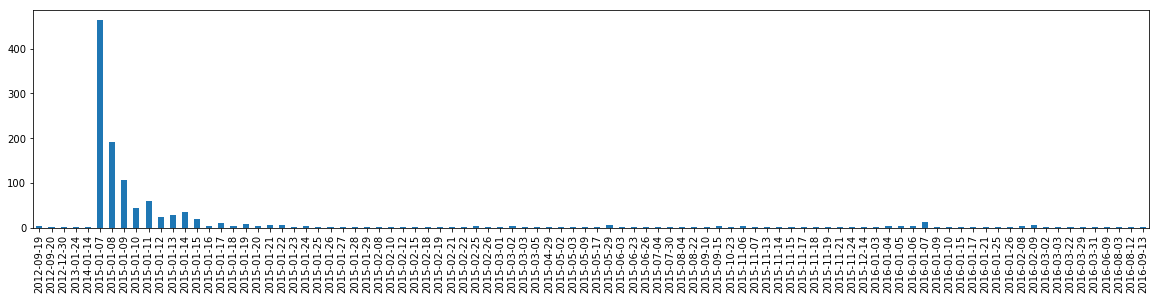

In [10]:
plot_frequency_tags(df_tag, 'day', "#charliehebdo", 100)

Let us now try this for events that take place every year at the same period, for example Eurovision and Paléo Festival.

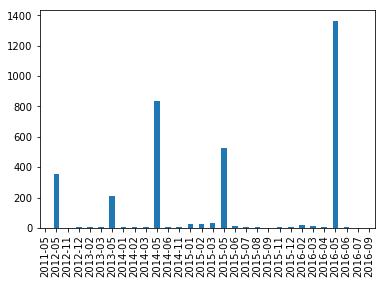

In [11]:
plot_frequency_tags(df_tag, 'month', "#eurovision", 30)

For Eurovision, we can clearly see a spike each year during the month of may, which is indeed when the contest takes place.

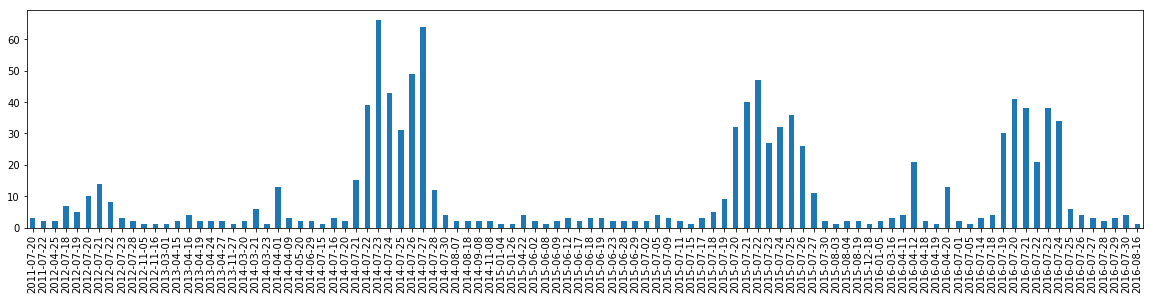

In [12]:
plot_frequency_tags(df_tag, 'day', "#paleo", 100)

For Paléo Festival, we can again see a spike each year during the end of month of July, but this time we can also see that it lasts about a week.

## 3.2 Geographic event localisation

Here we can use the geographic information of the tweets to determine the location of an event. To do so, we display on a map the geolocation of each tweet that mentions a given hashtag. The following function were implemented in order to create this map.

In [13]:
def popup_html(row):
    '''
        Return the html to create a popup for the dataframe row.
    '''
    return """
    <style>
    h3 {
        color: black;
        font-size: 16px;
        text-align: center;
    }
    </style>
    <h3> %s </h3>
    <h3> %s </h3>
    """ %( row.day, str(row.tag.replace("'", "").replace("[", "").replace("]", "")) )

def add_markers_to_map_(dataframe, map_, popup = True, maxClusterRadius = 10):
    '''
        Add the clusters of markers from the dataframe to the given map. 
    '''
    popups = []
    coordinates = []
    for index,row in dataframe.iterrows():
        if row.Latitude != '\\N' and row.Longitude != '\\N':
            coordinates.append([float(row.Longitude), float(row.Latitude)])
            if popup:
                popups.append(folium.Popup(popup_html(row)))
            else:
                popups.append("")
            
    marker_cluster = MarkerCluster(locations=coordinates, 
                                   popups=popups).add_to(map_)
           
def get_map_with_hasthtag(hashtag):
    '''
        Create a map with the markers for the given hashtag.
    '''
    swiss_coord = [46.8, 8.2]
    
    swiss_map = folium.Map(swiss_coord, zoom_start=8)
    
    # Get the dataframe of the tweet containing the hashtag.
    indexes = get_index_with_hashtag(df_tag, hashtag)
    event_df_tag = df_tag.iloc[indexes[0]]
    
    add_markers_to_map_(event_df_tag, swiss_map)
    
    return swiss_map

Now let us try this with Eurovision and Paléo Festival, which were already used as examples previously. As we can see in the maps below, Eurovision is an international event since the geographic repartitions of tweet is quite homogenous over Switzerland. On the other hand, if we look at the hashtag '#paleo', we can quickly see that it takes place in Nyon because there is a very high concentration of tweets about Paléo in that area.

In [14]:
get_map_with_hasthtag("eurovision")

In [ ]:
get_map_with_hasthtag("paleo")

# 4. Event detection

## 1. Filtering out irrelevant hashtags
<div style="background-color:red;padding:10px;margin:10px;color:white">
**TODO: Keep only unique tweet indices in the group_hashtag df, rewrite it and update the code that generates it. **
</div>

In [8]:
def get_unique_authors_from_tweet_ids(tweet_ids):
    return len(np.unique(df_tag.iloc[tweet_ids]['userId'].values))

In [4]:
group_df = group_hashtags.copy().head(100000)

# Get the number of times each hashtag was tweeted
group_df['tweets_nb'] = group_df['tweets_idx'].apply(lambda ls: len(ls))

# Get the number of unique users that tweeted each hashtag
group_df['nb_unique_authors'] = group_df['tweets_idx'].apply(lambda ids: len(np.unique(df_tag.iloc[ids]['userId'].values)))

group_df.sort_values('nb_unique_authors', ascending=False)

hashtag  \
28547                     #geneva   
81105                  #mountains   
69059                     #nature   
90124                  #beautiful   
34001                    #schweiz   
37739                     #italia   
4617                      #skiing   
59718                     #family   
17402                      #relax   
96557                  #christmas   
48866                     #luzern   
24493                         #nw   
79479                       #home   
88485                     #genève   
59685                    #zermatt   
63799                          #2   
56027                       #cold   
5198                   #swissalps   
36070                       #live   
72548                        #usa   
42977                       #city   
25259                 #buongiorno   
68933                       #fuck   
48602               #architecture   
11838                          #i   
8241                         #top   
92911                       #cute   
66086                       #tpmp   
43662                      #white   
91908                    #sunrise   
...                           ...   
37899                  #troisième   
37896              #fautlesoigner   
37894              #lacrimefacili   
37893      #despolémiquesensuisse   
37892                   #yayornay   
37891                #moléculaire   
37889                  #monichedi   
37888                       #جبيف   
37910                  #inventare   
37912                 #maidiregol   
37936                    #قطر٢٠٢٢   
37913                #أعيش_في_بلد   
37935             #estremidelvino   
37934            #keepoffthechips   
37933               #bertinypedro   
37930             #teamsexmachine   
37929  #منظر_تتمناه_الموسم_القادم   
37927                #macobsessed   
37926           #ganassiandsauber   
37925           #tweetcommeleynux   
37924                #greatvoices   
37922              #machebruttofa   
37921                   #naoshima   
37919            #freestyledusoir   
37918           #ritabottillwedie   
37917               #beingturkish   
37916             #chamonixchurch   
37915           #highlinegalleria   
37914                    #asbjørn   
99999        #immarykayconsultant   

                                              tweets_idx  tweets_nb  \
28547  [2796, 4217, 5694, 5838, 6638, 7035, 8239, 895...      26970   
81105  [13083, 35305, 37751, 37811, 37956, 38500, 436...       6914   
69059  [2883, 3951, 4022, 4077, 5177, 5675, 7453, 781...       7899   
90124  [17532, 27933, 30413, 37359, 39059, 41882, 418...       5963   
34001  [595, 4593, 4655, 6988, 7439, 7588, 8279, 8617...      10004   
37739  [3095, 4946, 14241, 18874, 25157, 30919, 38581...       4845   
4617   [21630, 24090, 27807, 28261, 32241, 33959, 747...       4250   
59718  [14269, 24149, 29531, 35186, 43515, 52717, 796...       2884   
17402  [13781, 28537, 34243, 34509, 34701, 35871, 467...       2910   
96557  [4128, 4440, 5041, 5050, 15485, 19489, 19837, ...       2940   
48866  [41, 966, 1838, 2415, 5957, 6115, 6116, 6522, ...       4833   
24493  [15305, 20708, 30505, 30582, 30651, 30933, 317...       7507   
79479  [1569, 2321, 3348, 9449, 13887, 16050, 18843, ...       2664   
88485  [16154, 18281, 21753, 26969, 27148, 31024, 315...       3952   
59685  [6008, 6030, 6039, 6907, 12729, 13499, 13506, ...       3863   
63799  [1956, 4648, 5584, 6312, 7666, 7673, 9146, 110...       1712   
56027  [4967, 22622, 23944, 24201, 37751, 37811, 3795...       1855   
5198   [23665, 32229, 34183, 35046, 61796, 61803, 669...       2707   
36070  [1707, 9689, 16186, 19313, 22285, 23843, 26118...       2271   
72548  [1398, 4534, 7633, 9319, 9395, 11529, 13152, 1...       2142   
42977  [24495, 26908, 44279, 44444, 44454, 47276, 526...       2151   
25259  [16471, 19020, 20417, 21190, 21595, 21858, 219...       5045   
68933  [19604, 30408, 30869, 30953, 31087, 34493, 346...       1673   
48602  [3413, 4743, 5682, 1

In [71]:
group_df_filtered = group_df.copy()
#group_df_filtered = group_df_filtered[group_df_filtered['tweets_nb'] > 100]
group_df_filtered = group_df_filtered[group_df_filtered['nb_unique_authors'] > 50]
group_df_filtered.count()

hashtag              725
tweets_idx           725
tweets_nb            725
nb_unique_authors    725
dtype: int64

In [75]:
#group_hashtags = group_hashtags.set_index('hashtag')

In [77]:
#group_df_filtered = group_df_filtered.set_index('hashtag')

## 2. Basic algorithm

In [78]:
def get_unique_author_per_day(df):
    """Returns a dictionnary containing for each hashtags a dictionnary of dates
       and the corresponding number of user that has tweeted this hashtag that day."""
    
    dic_tag_days = {}
    
    for idx, row in df.iterrows():
        grouped_day = df_tag.iloc[row['tweets_idx']].groupby('day')
        dic_tag_days[idx] = grouped_day.apply(lambda x: get_unique_authors_from_tweet_ids(x.index.values)).to_dict()
    
    return dic_tag_days

In [80]:
dic_tag_days = get_unique_author_per_day(group_df_filtered.head(100))
dic_tag_days

{'#420': {'2012-04-20': 2,
  '2012-12-29': 1,
  '2013-01-09': 1,
  '2013-01-26': 1,
  '2013-01-28': 1,
  '2013-02-20': 1,
  '2013-03-09': 1,
  '2013-03-11': 1,
  '2013-03-23': 1,
  '2013-04-03': 1,
  '2013-04-04': 1,
  '2013-04-06': 1,
  '2013-04-07': 2,
  '2013-04-08': 1,
  '2013-04-09': 1,
  '2013-04-10': 2,
  '2013-04-11': 1,
  '2013-04-12': 1,
  '2013-04-13': 1,
  '2013-04-14': 1,
  '2013-04-15': 1,
  '2013-04-16': 1,
  '2013-04-17': 1,
  '2013-04-19': 1,
  '2013-04-20': 4,
  '2013-04-21': 1,
  '2013-04-22': 1,
  '2013-04-23': 1,
  '2013-04-24': 2,
  '2013-04-25': 1,
  '2013-04-26': 1,
  '2013-04-27': 1,
  '2013-04-28': 1,
  '2013-04-29': 1,
  '2013-04-30': 1,
  '2013-05-01': 1,
  '2013-05-02': 1,
  '2013-05-03': 1,
  '2013-05-04': 1,
  '2013-05-05': 1,
  '2013-06-23': 1,
  '2013-10-04': 1,
  '2013-10-07': 1,
  '2013-10-11': 1,
  '2013-10-26': 1,
  '2013-11-11': 1,
  '2013-11-28': 1,
  '2013-12-01': 2,
  '2013-12-31': 2,
  '2014-01-02': 1,
  '2014-01-10': 1,
  '2014-01-19': 1,
  '2

In [95]:
def plot_hashtag_occurence_for_dates(hashtag, dic_tag_days, start_date, end_date):
    """Display a bar plot of the number of unique users that tweeted the given hashtag between the given dates."""
    
    delta = end_date - start_date
    nb_days = delta.days + 1
    
    dates = [str(start_date + timedelta(days=i)) for i in range(nb_days)]
    nb_authors = [dic_tag_days.get(hashtag).get(d, 0) for d in dates]
    
    width = 0.5
    left = [l for l in range(nb_days)]
    plt.figure(figsize=(16,4))
    plt.bar(left, nb_authors, width=width)
    plt.xticks(left, dates, rotation='vertical')
    plt.show()

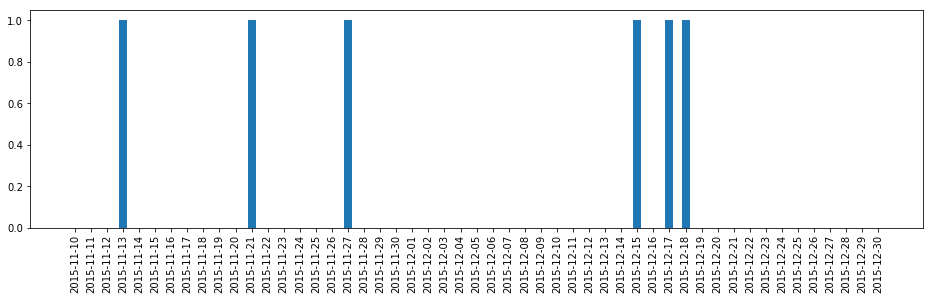

In [96]:
plot_hashtag_occurence_for_dates('#chicago', dic_tag_days, date(2015, 11, 10), date(2015, 12, 30))

## 3. Algorithm Optimization

## 4. Event localisation

(Please refer to the README.md file for a more precise description)